<a href="https://colab.research.google.com/github/JARACH-209/AI-ML_Lab/blob/master/ML_Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
%matplotlib inline

X,Y = load_iris(return_X_y = True)

In [293]:
class SOM:
    def _init_(self):
        self.weights = None
        self.score_per_epoch = {}
        self.learning_rate = 0.1
        self.best_weights = None
        self.classes = None

    def euclidean_distance(self, p1, p2):   
        return np.linalg.norm(p1-p2)
    
    def weight_updation(self, weights, distances, point):
        # best_neuron = np.argmin(weights)    #index of closest neuron
        temp = np.array(distances).argsort().argsort()
        ranks = [(j+1) for j in temp]
        for i in range(len(weights)):
            weights[i] += (self.learning_rate/ranks[i]**2)*(point - weights[i])
            # Damped Learning rate follows inverse square law
        return weights

    def predict(self,x):
        y = np.zeros(len(x)).astype(int)
        distances = np.zeros(self.classes)
        for j in range(len(x)): 
            for i in range(len(self.best_weights)):
                distances[i] = self.euclidean_distance(self.best_weights[i],x[j])
            y[j] = np.argmin(distances)
        return y
    def process_predict(self,x):
        y = np.zeros(len(x)).astype(int)
        distances = np.zeros(self.classes)
        for j in range(len(x)): 
            for i in range(len(self.weights)):
                distances[i] = self.euclidean_distance(self.weights[i],x[j])
            y[j] = np.argmin(distances)
        return y

    def fit(self, X, learning_rate = 0.01, iterations = 100,classes = 0):
        self.learning_rate = learning_rate
        max_sscore = -1

        # Assinging random datapoint in train set as weights to neurons
        if classes == 0:
            neurons = len(X[0])**2 
        else: neurons = classes
        self.classes = neurons
        score_per_epoch = {}
        self.weights = np.zeros((classes,len(X[0])))
        while True:
            random_indexes = np.random.randint(len(X),size=classes).astype(float)
            if len(set(random_indexes))==len(random_indexes):
                break
        p=0
        for each in random_indexes:
            self.weights[p] = X[int(each)]
            p+=1
        self.best_weights = self.weights

        score_per_epoch = {}
        for epoch in range(iterations):
            print("Iteration ",epoch)
            for point in X:
                distances = np.zeros(len(X[0]))
                old_weights = self.weights
                for i in range(len(self.weights)):
                    distances[i] = self.euclidean_distance(self.weights[i],point)
                self.weights = self.weight_updation(self.weights, distances, point)
            sscore = silhouette_score(X,self.process_predict(X))
            score_per_epoch[epoch] = sscore
            if sscore < max_sscore:
                self.best_weights = self.weights 
        self.score_per_epoch = score_per_epoch


In [275]:
import math
class K_Means():
    def __init__(self,k=1,iterations = 100,elbow=False,k_max=10):
        self.k = k
        self.iterations = iterations
        self.elbow_flag = elbow
        self.k_max = k_max
        self.best_k = None
        self.elbow_reductions = None
        self.k_centroids = None
        self.y = None
        self.variances = None

    def final_centroids(self):
        return np.array(self.k_centroids)

    def get_variance(self,X,y,k_centroids):
        # sum of squares of distances between points and their centroids
        temp = 0
        for j in range(len(k_centroids)):
            for point,cluster in zip(X,y):
                if cluster == j:
                    temp += self.euclidean_distance(point,k_centroids[j])**2 
        return math.sqrt(temp)

    def euclidean_distance(self, p1, p2):
        # math.dist can gives distance between points of any dimensionality 
        # Unfortunately Colab works on python3.6 and dist is in 3.8
        #return math.dist(p1,p2)     
        return np.linalg.norm(p1-p2)

    def get_centroids(self,X,y,k):
        k_centroids = []
        cluster_indexes = []
        for j in range(k):
            cluster_indexes.append([i for i in range(len(y)) if y[i] == j])
        # Finding means of all the clusters
        # Summing all the coordinates in all the dimensions having same cluster 
        # label and taking a mean
        for cluster in cluster_indexes:
            cluster_mean = 0
            for i in cluster:
                 cluster_mean += X[i]
            num = len(cluster) if len(cluster) >0 else 1
            k_centroids.append(np.array(cluster_mean/num))
            
            # k = number of clusters and their labels as well.
            # Taking mean of all the points having same cluster label 
            # To get the mean coordinates find the mean of all the dimensional coordinates
            # E.g -> [x,y,z] otherwise mean will be a number and for distance dims must be equal
            # experession below will give direct mean instead of coordinates.
        # k_centroids.append((np.mean([point for point,cluster in zip(X,y) if cluster == j])))
        return k_centroids

    def get_cluster(self,X,k_centroids):
        y = np.zeros(len(X),dtype=int)
        min_dist = None
        cluster = 0
        dist = None
        for i in range(len(X)):
            
            min_dist = self.euclidean_distance(X[i],k_centroids[0])
            cluster = 0
            for j in range(len(k_centroids)):
                dist = self.euclidean_distance(X[i],k_centroids[j])
                if dist < min_dist:
                    min_dist = dist
                    cluster = j
            y[i] = int(cluster)
        return y

    def clustering(self,X, k):
        min_variance = None
        variance = None
        best_centroids = None
        for i in range(self.iterations):
            y = np.zeros(len(X),dtype=int)
            k_centroids = []
            variance = []

            # intializes distinct random k points from dataset
            while True:
                rand_points = np.random.randint(len(X),size=(k))
                if len(set(rand_points)) == len(rand_points):
                    break
            for points in rand_points:
                k_centroids.append(X[points])
            min_variance = self.get_variance(X,y,k_centroids)
            check_count = 0
            # Clustering Loop
            while True:
                check_count += 1
                # Prevents the loop from going to infinity in any possible case
                if check_count > len(X)*10:
                    raise Exception("Error in Cluster Loop. Infite Looping. Run again.") 
                
                # cluster labeling with given centroids
                y = self.get_cluster(X,k_centroids) 
                
                # Generates new centroids by taking mean of all labels
                new_centroids = self.get_centroids(X,y,k)
                if np.array_equal(k_centroids,new_centroids):
                    variance = self.get_variance(X,y,new_centroids)
                    break
                else:
                    k_centroids = new_centroids

            variance = self.get_variance(X,y,new_centroids)
            if variance < min_variance:
                min_variance = variance
                best_centroids = k_centroids
        return best_centroids,min_variance

    def elbow_clustering(self,X):
        var_reductions = np.zeros(self.k_max+1)
        variance = None
        variances = []
        for i in range(1,int(self.k_max+1)):
            _, variance = self.clustering(X,i)
            variances.append(variance)
        for i in range(len(variances)-1):
            var_reductions[i+1] = abs(variances[i+1]-variances[i])
        self.elbow_reductions = var_reductions
        self.variances = variances
        return var_reductions
    
    def predict(self,X):
        y = self.get_cluster(X,self.k_centroids)
        return np.array(y).astype(int)

    def fit(self, X):
        best_k = None
        k = self.k
        centroids = []
        y = []
        if self.elbow_flag:

            #Gives variances for all the values of K
            #implement automation later
            self.elbow_clustering(X)

        else:
            centroids, min_var = self.clustering(X,k) #final centroids are stored globally
            y = self.get_cluster(X, centroids)
            self.k_centroids = centroids
            self.y = y
            return y
            


In [289]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size = 1)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
scaler = StandardScaler().fit(x_test)
x_test = scaler.transform(x_test)

In [ ]:
som = SOM()
som.fit(X,classes = 3,iterations=100)

In [ ]:
k_means = K_Means(k=3)
k_means.fit(X)

In [300]:
y_k_pred = k_means.predict(X)
y_pred = som.predict(X)

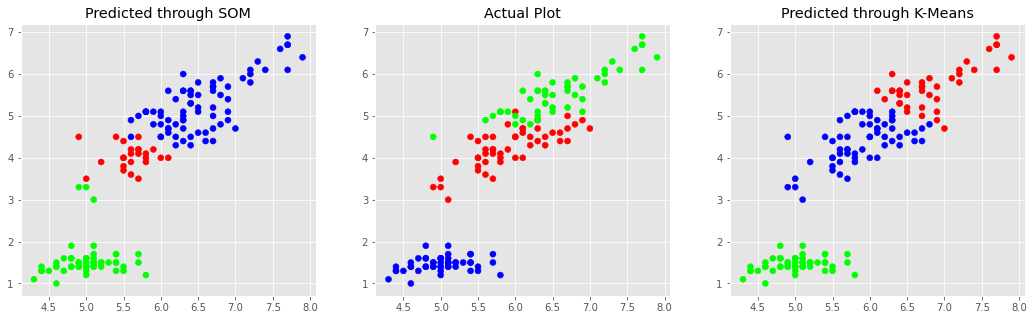

In [302]:
xdf = pd.DataFrame(X)
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
axes[0].scatter(xdf[0],xdf[2],c=y_pred,cmap='brg')
axes[1].scatter(xdf[0],xdf[2],c=Y,cmap='brg')
axes[2].scatter(xdf[0],xdf[2],c=y_k_pred,cmap='brg')
axes[0].title.set_text("Predicted through SOM")
axes[1].title.set_text("Actual Plot")
axes[2].title.set_text("Predicted through K-Means")

#Colours DO NOT matter

In [307]:

print("Silouhette Coefficient of SOM \t\t%0.2f"%(silhouette_score(X,som.predict(X))*100))
print("Silouhette Coefficient of K-Means \t%0.2f"%(silhouette_score(X,k_means.predict(X))*100))
print("Silouhette Coefficient of Actual Data \t%0.2f"%(silhouette_score(X,Y)*100))

Silouhette Coefficient of SOM 		46.71
Silouhette Coefficient of K-Means 	55.12
Silouhette Coefficient of Actual Data 	50.35
